## Imports

In [230]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from CellAnalyzer import CellAnalyzer
import vetsuisse25_imaging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
virus = "229E" # "229E" or "MERS"
in_path = "../imaging_data/21122022_images_jinglecells_SO_AK/" + virus

In [261]:
ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


## Data loading and inspection

Create an object with the path to the data.

In [ ]:
# ca = CellAnalyzer(in_path)

>>> GPU activated? NO


Display the data table.

In [262]:
df, imgs = ca.read_data()
display(df)

7 images loaded


,condition,donor,time,date,sample,replicate,sample_id,mode1,mode2,filename,filepath
0,229E,BEC5,48h,2021-12-22,00,1,BEC5_1,R3D,D3D,229E_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
1,229E,BEC5,48h,2021-12-22,02,2,BEC5_2,R3D,D3D,229E_BEC5_48h_21.12.22.02_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
2,229E,BEC5,48h,2021-12-22,03,3,BEC5_3,R3D,D3D,229E_BEC5_48h_21.12.22.03_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
3,229E,BEC6,48h,2021-12-22,01,1,BEC6_1,R3D,D3D,229E_BEC6_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
4,33mock,BEC5,48h,2021-12-22,02,1,BEC5_1,R3D,D3D,33mock_BEC5_48h_21.12.22.02_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
5,33mock,BEC6,48h,2021-12-22,01,1,BEC6_1,R3D,D3D,33mock_BEC6_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
6,33mock,BEC6,48h,2021-12-22,02,2,BEC6_2,R3D,D3D,33mock_BEC6_48h_21.12.22.02_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...


Check dimensions.

In [263]:
imgs[0].shape

(4, 68, 960, 960)

Create projections.

In [264]:
projections = ca.create_projections(types=["max", "max", "max", "max"]) # Projection options: max, min, mean, median

In [265]:
print(ca.projections[0].shape)
print(ca.projections_types)

(4, 960, 960)
['max', 'max', 'max', 'max']


## Segmentation

In [266]:
# masks, flows, styles, imgs_dn, outlines = ca.segment_cells(channels=[3,1]) # Channels for: Cytoplasm, Nucleus

Check to make sure the data was loaded correctly (hiding the irrelevant columns); after segmentation, the table now includes information about the IDs of the cells in each sample.

In [267]:
df = ca.samples_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
df

,condition,donor,replicate,sample_id
0,229E,BEC5,1,BEC5_1
1,229E,BEC5,2,BEC5_2
2,229E,BEC5,3,BEC5_3
3,229E,BEC6,1,BEC6_1
4,33mock,BEC5,1,BEC5_1
5,33mock,BEC6,1,BEC6_1
6,33mock,BEC6,2,BEC6_2


And we now also have a cells table, which contains the information about the sample plus cell-specific information.

In [268]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,sample_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,cil_inf_pop
cell_id,,,,,,,,,,,
1201,33mock,BEC6,2,BEC6_2,6839.446999,3.835021,3534.795019,3.548364,partial,positive,cil_pos_inf_par
1202,33mock,BEC6,2,BEC6_2,5185.324748,3.714776,3417.686450,3.533732,partial,negative,cil_neg_inf_par
1203,33mock,BEC6,2,BEC6_2,6587.053950,3.818691,3781.516859,3.577666,partial,negative,cil_neg_inf_par
1204,33mock,BEC6,2,BEC6_2,7844.070552,3.894541,3199.999387,3.505150,negative,positive,cil_pos_inf_neg
1205,33mock,BEC6,2,BEC6_2,6220.638658,3.793835,2820.527227,3.450330,negative,negative,cil_neg_inf_neg


Save segmentation results, just for viusalization purposes.

In [269]:
# ca.save_segmentation_imgs(background_channels=[4,2], overwrite=True)

Save the data, so we can load it later.

In [270]:
# ca.save(overwrite=True)

## Calculate Cell Signals

Mean, or alternatively Median.

In [ ]:
signals_mode = "mean" # "mean" or "median"

In [272]:
cells_df, signals_masks = ca.calculate_cell_signals({"cilia": 4, "inf": 2}, mode=signals_mode)

Check the new columns in the data table.

In [273]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,sample_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,cil_inf_pop
cell_id,,,,,,,,,,,
1201,33mock,BEC6,2,BEC6_2,6839.446999,3.835021,3534.795019,3.548364,partial,positive,cil_pos_inf_par
1202,33mock,BEC6,2,BEC6_2,5185.324748,3.714776,3417.686450,3.533732,partial,negative,cil_neg_inf_par
1203,33mock,BEC6,2,BEC6_2,6587.053950,3.818691,3781.516859,3.577666,partial,negative,cil_neg_inf_par
1204,33mock,BEC6,2,BEC6_2,7844.070552,3.894541,3199.999387,3.505150,negative,positive,cil_pos_inf_neg
1205,33mock,BEC6,2,BEC6_2,6220.638658,3.793835,2820.527227,3.450330,negative,negative,cil_neg_inf_neg


We can also get the masks with the signals for each cell.

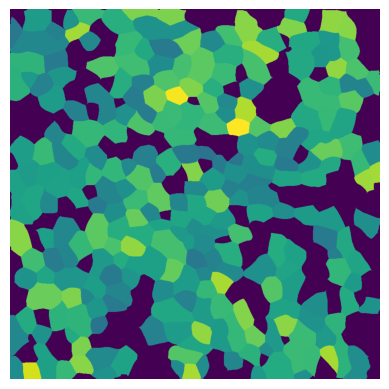

In [274]:
ex_signal_mask = ca.signals_masks["cilia"][3]
plt.imshow(ex_signal_mask)
plt.axis("off")
plt.show()

Save the data.

In [275]:
# ca.save(overwrite=True)

## Define inf threshold and bin cells

### Infection

In [276]:
mock_inf_log10 = ca.cells_df[cells_df["condition"].str.contains("mock")]["inf_mean_log10"]
inf_log10_thresh = mock_inf_log10.mean() + 3 * mock_inf_log10.std()
inf_log10_thresh_low = mock_inf_log10.mean() + 1 * mock_inf_log10.std()
threshs = [inf_log10_thresh, inf_log10_thresh_low]
print(f"Inf log10 thresholds: {inf_log10_thresh_low} | {inf_log10_thresh}")

Inf log10 thresholds: 3.5164063539947428 | 3.5905367908489296


In [277]:
ca.bin_cell_signal("inf", thresh=threshs)

In [278]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,cil_inf_pop
cell_id,,,,,,,,,,,
101,229E,BEC5,1,BEC5_1,6497.841971,3.812769,511.963466,2.709239,negative,negative,cil_neg_inf_neg
102,229E,BEC5,1,BEC5_1,9640.748302,3.984111,658.948159,2.818851,negative,positive,cil_pos_inf_neg
103,229E,BEC5,1,BEC5_1,8631.185060,3.936070,700.369745,2.845327,negative,positive,cil_pos_inf_neg
104,229E,BEC5,1,BEC5_1,5433.377873,3.735070,561.114377,2.749051,negative,negative,cil_neg_inf_neg
105,229E,BEC5,1,BEC5_1,6613.782108,3.820450,569.903922,2.755802,negative,negative,cil_neg_inf_neg


In [279]:
cells_df["inf"].value_counts()

inf
negative    1334
partial      173
positive      27
Name: count, dtype: int64

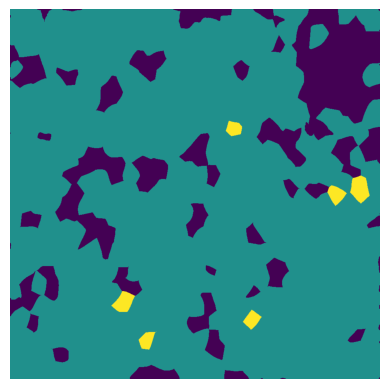

In [280]:
ex_bins_mask = ca.bin_masks["inf"][4]
plt.imshow(ex_bins_mask)
plt.axis("off")
plt.show()

In [281]:
virus_data = cells_df[cells_df["condition"].str.contains(virus)]

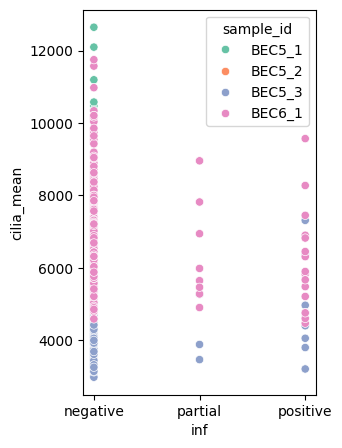

In [282]:
fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
sns.scatterplot(data=virus_data, x='inf', y='cilia_'+signals_mode, palette="Set2", hue="sample_id", ax=ax)
plt.show()

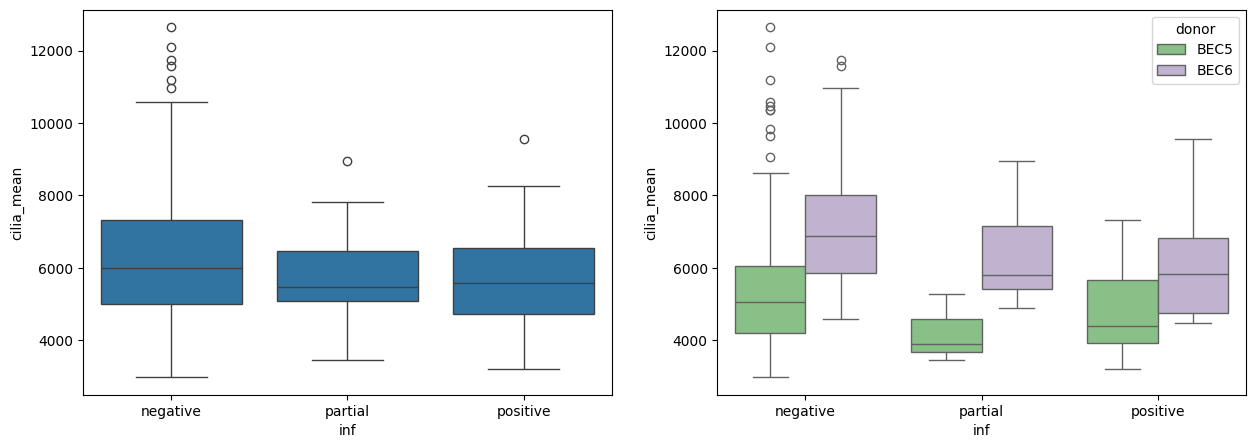

In [283]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
sns.boxplot(data=virus_data, x='inf', y='cilia_'+signals_mode, ax=ax[0])
sns.boxplot(data=virus_data, x='inf', y='cilia_'+signals_mode, ax=ax[1], palette="Accent", hue="donor")
plt.show()

### Cilia

In [284]:
ca.bin_cell_signal("cilia", thresh=None)

Using Otsu's method to find the threshold for cilia_mean_log10: 3.830079323048743


In [285]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,cil_inf_pop
cell_id,,,,,,,,,,,
101,229E,BEC5,1,BEC5_1,6497.841971,3.812769,511.963466,2.709239,negative,negative,cil_neg_inf_neg
102,229E,BEC5,1,BEC5_1,9640.748302,3.984111,658.948159,2.818851,negative,positive,cil_pos_inf_neg
103,229E,BEC5,1,BEC5_1,8631.185060,3.936070,700.369745,2.845327,negative,positive,cil_pos_inf_neg
104,229E,BEC5,1,BEC5_1,5433.377873,3.735070,561.114377,2.749051,negative,negative,cil_neg_inf_neg
105,229E,BEC5,1,BEC5_1,6613.782108,3.820450,569.903922,2.755802,negative,negative,cil_neg_inf_neg


In [286]:
cells_df["cilia"].value_counts()

cilia
positive    790
negative    744
Name: count, dtype: int64

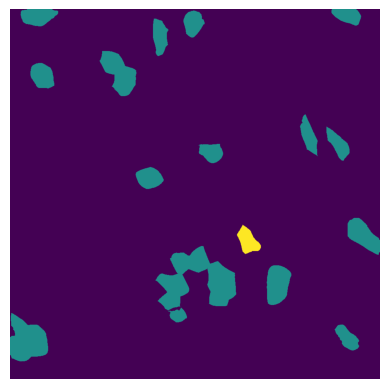

In [287]:
ex_bins_mask = ca.bin_masks["cilia"][1]
plt.imshow(ex_bins_mask)
plt.axis("off")
plt.show()

In [288]:
virus_data = cells_df[cells_df["condition"].str.contains(virus)]

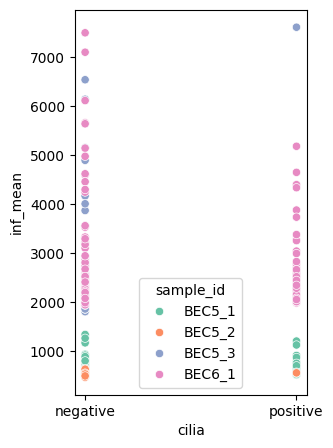

In [289]:
fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
sns.scatterplot(data=virus_data, x='cilia', y='inf_'+signals_mode, palette="Set2", hue="sample_id", ax=ax)
plt.show()

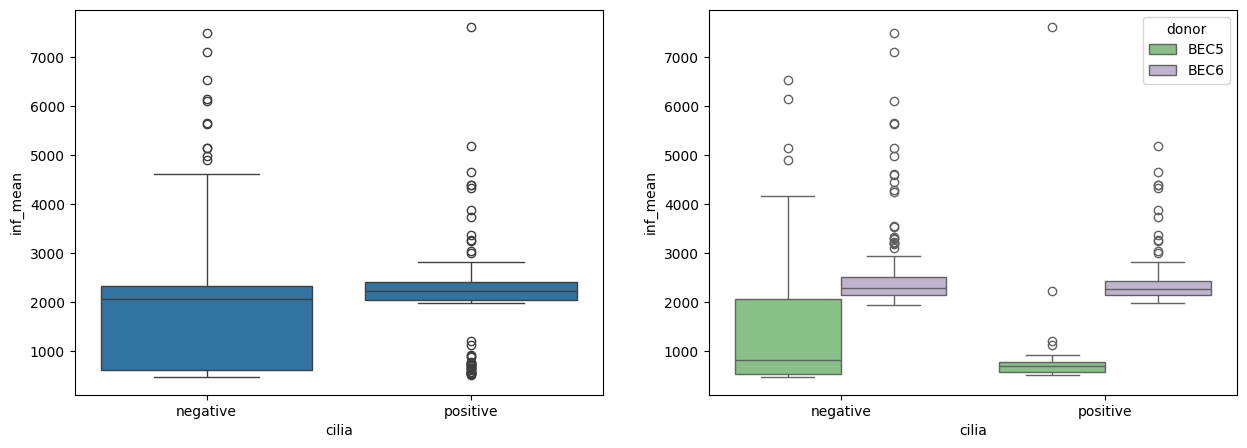

In [290]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), dpi=100)
sns.boxplot(data=virus_data, x='cilia', y='inf_'+signals_mode, ax=ax[0])
sns.boxplot(data=virus_data, x='cilia', y='inf_'+signals_mode, ax=ax[1], palette="Accent", hue="donor")
plt.show()

### Save the data

In [291]:
# ca.save(overwrite=True)

## Extract the populations (bin combinations)

In [292]:
cells_df = ca.create_populations("cilia", "inf")

In [293]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df[100:105]

,condition,donor,replicate,sample_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,cil_inf_pop
cell_id,,,,,,,,,,,
101,229E,BEC5,1,BEC5_1,6497.841971,3.812769,511.963466,2.709239,negative,negative,cil_neg_inf_neg
102,229E,BEC5,1,BEC5_1,9640.748302,3.984111,658.948159,2.818851,negative,positive,cil_pos_inf_neg
103,229E,BEC5,1,BEC5_1,8631.185060,3.936070,700.369745,2.845327,negative,positive,cil_pos_inf_neg
104,229E,BEC5,1,BEC5_1,5433.377873,3.735070,561.114377,2.749051,negative,negative,cil_neg_inf_neg
105,229E,BEC5,1,BEC5_1,6613.782108,3.820450,569.903922,2.755802,negative,negative,cil_neg_inf_neg


In [294]:
cells_df["cil_inf_pop"].value_counts()

cil_inf_pop
cil_pos_inf_neg    681
cil_neg_inf_neg    653
cil_pos_inf_par    100
cil_neg_inf_par     73
cil_neg_inf_pos     18
cil_pos_inf_pos      9
Name: count, dtype: int64

Save population images just for visualization purposes.

In [295]:
# ca.save_population_imgs("cilia", "inf", outline_channel="white", overwrite=True)

Save the data.

In [296]:
# ca.save(overwrite=True)

## Visualize the results

In [297]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.groupby(["condition", "cilia", "inf"]).size().reset_index(name='count')

,condition,cilia,inf,count
0,229E,negative,negative,308
1,229E,negative,partial,8
2,229E,negative,positive,18
3,229E,positive,negative,159
4,229E,positive,partial,3
5,229E,positive,positive,6
6,33mock,negative,negative,345
7,33mock,negative,partial,65
8,33mock,positive,negative,522
9,33mock,positive,partial,97


In [298]:
filter = cells_df["condition"].str.contains(virus) & ~cells_df["inf"].str.contains("partial")
virus_data = cells_df[filter]

In [299]:
matrix = virus_data.pivot_table(index="cilia", columns="inf", values="sample_id", aggfunc="count")#.plot(kind="bar", stacked=True, figsize=(10, 5), rot=0)
matrix = matrix.reindex(columns=["negative", "positive"], index=["positive", "negative"]).fillna(0).astype(int)
# matrix = matrix.reindex(columns=["negative", "partial", "positive"], index=["positive", "negative"])
display(matrix)

inf,negative,positive
cilia,,
positive,159,6
negative,308,18


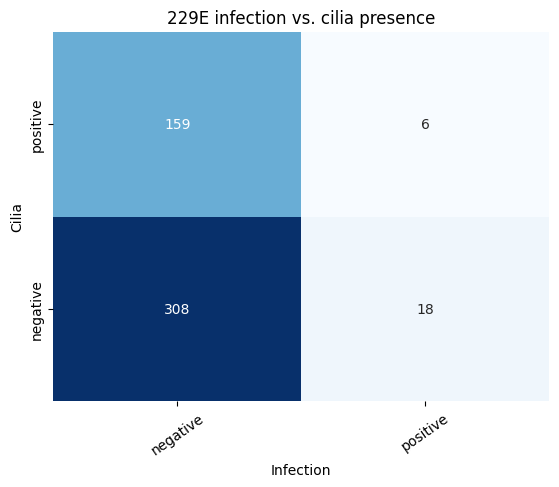

In [300]:
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"{virus} infection vs. cilia presence")
plt.xlabel("Infection")
plt.ylabel("Cilia")
plt.xticks(rotation=35)
plt.show()

inf
negative    0.340471
positive    0.250000
Name: positive, dtype: float64

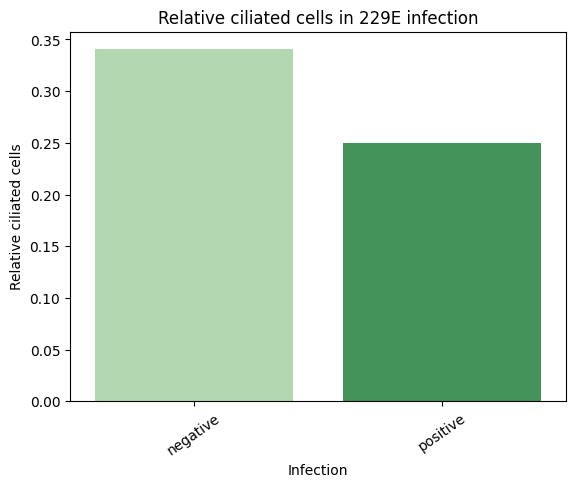

In [301]:
matrix_rel = matrix.div(matrix.sum(axis=0), axis=1)
# Show barplot with only the relative ciliated cells
rel_pos = matrix_rel.loc["positive"]
display(rel_pos)
sns.barplot(x=rel_pos.index, y=rel_pos.values, hue=rel_pos.index, palette="Greens")
plt.title(f"Relative ciliated cells in {virus} infection")
plt.xlabel("Infection")
plt.ylabel("Relative ciliated cells")
plt.xticks(rotation=35)
plt.show()